Set up the notebook environment for analysis

In [1]:
import sys
import os.path
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from utils import write_predictions_by_array, safe_div

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive') 
  if not os.path.isfile('SETTINGS.json'):
       # hard coded data directory in drive is used if SETTINGS.json not present 
       config={}
       config['DATA_DIR'] = '/content/gdrive/My Drive/kaggle-c1'
       with open('SETTINGS.json', 'w') as outfile:
         json.dump(config, outfile)

with open('SETTINGS.json') as config_file:
    config = json.load(config_file)

DATA_DIR = config['DATA_DIR']

print('Using DATA_DIR ', DATA_DIR)


Using DATA_DIR  /home/vvi/repos/c1-final-test/datadir


In [2]:
# Read input data and sample submission into pandas dataframe

DATA_FOLDER = DATA_DIR

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))
test_spec = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

In [3]:
# create monthly summaries of the trainintg data 
# as the task is to predict monthly sales counts
# this way we can (eventually) make the training and test data similarly rows in a data matrix

monthly_summary_train=transactions[['date_block_num','shop_id','item_id','item_cnt_day']].groupby(['date_block_num','shop_id','item_id'], as_index=False).sum()
monthly_summary_dec14 = monthly_summary_train[monthly_summary_train['date_block_num'] == 23]

# Exploratory data analysis

## Train/test split
As indicated in the task description, the training data for the task is in form of daily sales reports from the months of January 2013-October 2015. Based on these, the task is to predict the monthly December 2015 sales for given (shop_id, item_id) combinations. Thus the train/test split is identified to be temporal in nature.


We can once more confirm the time interval that is covered by the training data:

In [4]:
transactions.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


We see that the month variable date_block_num varies between 0 and 33. This indeed corresponds to months from January 2013 to October 2015.

## Investigating the test set

First tests the hypothesis that test set specification data exhaustively enumerates all possible 
(shop\_id, item\_id) combinations in some lists of shop and item id's:

In [5]:
sample_submission_with_ids = sample_submission.set_index('ID').join(test_spec.set_index('ID'))

In [6]:
print(sample_submission_with_ids.groupby(['shop_id','item_id']).ngroups)
sample_submission

214200


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


In [7]:
test_spec.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [8]:
42*5100

214200

That's it. Test data is enumerates all combinations in test item set and test shop set. Let's try to find out how the test item set and test shop set relate to corresponding sets in the training data. There are 22170 items and 60 shops listed in total, so test set lists only a subset of them.

In [9]:
monthly_summary_train.nunique()

date_block_num       34
shop_id              60
item_id           21807
item_cnt_day        446
dtype: int64

Training data has all the 60 shops but not all the items, 363 items are missing. Lets now find the overlap between test and training item sets.

In [10]:
test_items=np.array(test_spec['item_id'].unique())
print(len(test_items))
train_items=np.array(monthly_summary_train['item_id'].unique())
print(len(train_items))
traintest_common_items=np.intersect1d(test_items,train_items)
print(len(traintest_common_items))
test_categories=items[items['item_id'].isin(test_items)].item_category_id.unique()


5100
21807
4737


4737 items in the test are present in the training data. This leaves 363 items that occur only in the test data. This means that there are no items in the item list that do not occur in the transaction data at all.



In [11]:
test_novel_items=np.setdiff1d(test_items, traintest_common_items)
print(test_novel_items)
print(items[items['item_id'].isin(test_novel_items)])

[   83   140   168   173   204   237   249   254   302   402   428   430
   454   480   566   639   640   762   892   900   907  1184  1193  1246
  1252  1253  1254  1284  1386  1394  1434  1436  1437  1574  1575  1577
  1580  1585  1679  1683  1732  1864  1867  1884  1885  2322  2323  2324
  2325  2326  2327  2328  2420  2426  2427  2428  2434  2569  2722  2966
  3022  3023  3271  3272  3273  3282  3284  3338  3349  3354  3405  3407
  3408  3538  3571  3579  3604  3627  3760  3867  3908  3984  4060  4156
  4310  4318  4412  4642  4925  5025  5064  5121  5248  5268  5269  5320
  5321  5322  5441  5541  5569  5667  5721  5722  5812  5826  5843  5844
  5961  5963  6152  6153  6169  6259  6335  6439  6519  6520  6521  6522
  6523  6524  6525  6526  6527  6528  6529  6530  6531  6532  6533  6645
  6729  6730  6731  6732  6733  6734  6742  6743  6863  6891  6903  6996
  7094  7124  7572  7592  7607  7646  7647  7669  7727  7728  7729  7730
  7766  7782  7862  7926  8182  8191  8337  8354  8

There seems to be no obvious pattern in the index numbers nor in the names of the novel items.

It seems plausible that the test set has been generated from monthly summary 
of transaction data such as the trainig data, querying just the items and shops that are present in the December 2015 transactions.

Another hypotheses would be that the queried test data includes shops and items that are no longer active in Dec 15 (=have sales figures 0), which seems less likely.

### Test set split between public and private leaderboards

The entries in submissions are used for determining the score on both public and private leaderboards. We can probe the leaderboards purpose-crafted artificial submissions to find out exactly the split of the test data rows between public and private leaderboards. This is done in the following.

Let's try to figure out how the test set is split into public and private parts. We have already figured out that the test specification enumerates all query pairs of form (shop, item), where shop is one of the shops active (=with transaction data) and item \in {test_items}. Test items is the set of all items involved in any transaction during Dec 15.

Furthermore, from the provided contest description it is known that test data splits about 35:65 between public and private parts.

The division could be to 1) split the queried pairs disjointly into public and private parts, or 2) split the individual transactions into public and private, even within a queried pair. In 2) the predictions and score would have to be scaled appropriately for the evaluation.

Let's probe the leaderboard to find out which is the case. We are allowed 10 submissions/day via course assignment and 5 submissions/day via Kaggle competition.

We may be able to see if the split in deed is either 1) or 2) by submitting otherwise zeros but setting one random id to a large value. In case 1) there should be approximately similar change in score 35% of the time, and no change 65% of time. In 2) there should be a score change practically every time.

Let's generate 13 pairs + baseline to see, what might be the case:

Find constant that minimizes clipped rmse for dec14

In [12]:
LARGE_VALUE = 25*sample_submission.shape[0]
pred = np.zeros(sample_submission.shape[0])

write_predictions_by_array(pred, 'baseline0.csv')

np.random.seed(43)

n_random=13

index_to_perturb = np.random.randint(low=0, high = sample_submission.shape[0], size = n_random)

for idx in index_to_perturb:
  pred = np.zeros(sample_submission.shape[0])
  pred[idx] = LARGE_VALUE
  fn = 'single-perturbed-'+str(idx)+'.csv'
  write_predictions_by_array(pred, fn)

We evaluate the generated submissions on the leaderboard and collect the results in the following table:
(not all the results are put in the table. We stopped when the pattern became obvious)

| Perturbed index|Assignment score (public/private)| Kaggle public LB score|
|---|---|---|
baseline | 1.250/1.237 | |
14148 || 1.250|
28507 | 1.250 / 14312 |
105303 | 1.250 / 14311 | 1.250 |
125205 | | 1.250 |
129082 ||1.250|
147394 || 19659|
150848 | 19659 /1.237 |
|---|---|---|
137699 | 1.250 / 14312 ||
137700 | 19659 / 1.237 ||

Now it seems clear that the split follows really pattern 1) of distinct public and private test sets, 
since altering the prediction for a single test index affects 
only either public or private LB score, not both simultaneously. 
It looks like private part would be first in its entirety and thereafter the public part.
This is because perturbing small test indices changes only the private score, and large indices affect only the public score. 

Lets try to find the splitting point. 0.65 \* 42 shops ~ 27 shops

27 \* 5100=137700

Try perturbing indices 137699 and 137700. 
...
Seems we found the split point.


In conclusion, we have identified that the private and public LB scores are calculated from a distinct set of test set entries. 
The entries corresponding to the private part are in the beginning of the test set.

The practical significance of this identification is minor since we can directly evaluate the submissions on both public 
and private leaderboards via the Coursera grader.

## Further analysis of the data set

Let's now visualise the activity times of all the shops:

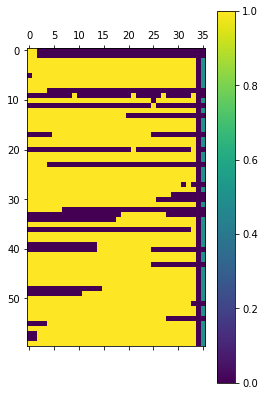

In [13]:
shop_activity_matrix = np.zeros((shops.shape[0],36))

test_shops=test_spec['shop_id'].unique()
for shop in test_shops:
  shop_activity_matrix[shop,35]=0.5

for timeidx in range(36):
  df_month = monthly_summary_train[monthly_summary_train['date_block_num'] == timeidx]
  active_shops = np.array(df_month['shop_id'].unique())
  for shop in active_shops:
    shop_activity_matrix[shop,timeidx] = 1

plt.matshow(shop_activity_matrix)
plt.colorbar()
plt.show()

Based on shop activity visualisation we notice that:
- usually the shops open at some point in time and then operate every month until the shop ceases to be active
- some shops are no longer active in Dec 2015
- training data ends in Oct 15. There's one month gap (Nov 15) before the test period Dec 15
- training data does not include (accidentally) data for the test period
- all the shops queried in test data are well established shops that have been in continuous operation long time until the end of training period, except for shop 36
  - for shop 36 just one active month in the end of the training period
      - maybe not even full month, check
        - opened only 18.10.
  - shop name Новосибирск ТРЦ "Галерея Новосибирск"	seems legit for a newly opened shop
  - may need special treatment
- the are some peculiar "shops"
    - shop 11 seems to be just mistakenly created alias of shop 10 for one month -> merge these two
    - similarly, shops 0 and 1 probably are aliases of the Jakutsk shops 57 and 58 
  - shop 09 is active only during isolated months. Name translated by google translator Выездная Торговля -> outbound trade (not a real shop at all)
  - shop 20 (Москва "Распродажа" -> moscow sale) has only two active months. Something special here, maybe a sales event of some sort. Perhaps remove from training data.





Check whether last training month data completely covers the month 

In [14]:
print(transactions[transactions['date_block_num']==33].date.sort_values())
print(transactions[transactions['date_block_num']==32].date.sort_values())

2889517    01.10.2015
2909775    01.10.2015
2915013    01.10.2015
2883775    01.10.2015
2883774    01.10.2015
              ...    
2932890    31.10.2015
2883909    31.10.2015
2899883    31.10.2015
2887587    31.10.2015
2918813    31.10.2015
Name: date, Length: 53514, dtype: object
2866202    01.09.2015
2865890    01.09.2015
2864674    01.09.2015
2869698    01.09.2015
2853358    01.09.2015
              ...    
2861917    30.09.2015
2847256    30.09.2015
2855478    30.09.2015
2847270    30.09.2015
2838967    30.09.2015
Name: date, Length: 50588, dtype: object


Dates seem to range from start of month to end and there are more transactions than in the preceding month. Thua also the data from the last training month (Oct 2015) is probably ok. This may be important, as the last training month has the smallest temporal distance from the test month and likely has data statistics most similar to the test month (among all training months).

## Overall target distribution

The following visualises the distribution monthly sales for each individual (item_id, shop_id) combination separately,  
over all the training data:

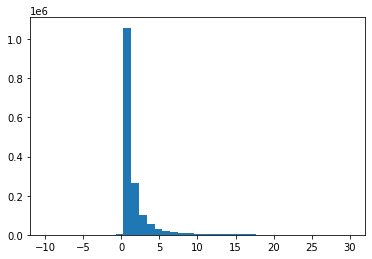

In [15]:
plt.hist(monthly_summary_train.item_cnt_day, bins=np.linspace(-10,30,40))
plt.show()

This is the distribution of the target variable that we are trying to predict for the test set. 
We notice that most typical sales count is 0. Of the non-zero counts, the count 1 is clearly most typical.

Similarly, following shows the distribution of shopwise sales count over all the training data:

In [16]:
monthly_summary_train.groupby(['date_block_num','shop_id']).sum().item_cnt_day

date_block_num  shop_id
0               0          5578.0
                1          2947.0
                2          1146.0
                3           767.0
                4          2114.0
                            ...  
33              55         1972.0
                56         1263.0
                57         2316.0
                58         1446.0
                59          790.0
Name: item_cnt_day, Length: 1586, dtype: float64

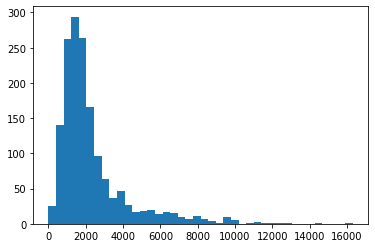

In [17]:
plt.hist(monthly_summary_train.groupby(['date_block_num','shop_id']).sum().item_cnt_day, bins=40)
plt.show()

We see that each shop typically sells a few thousand items each month.

### Development of sales over time

First overall sales counts


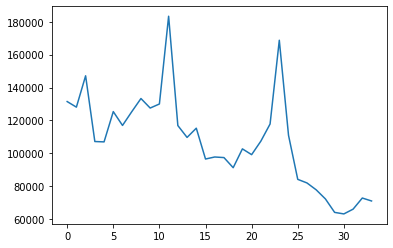

(34,)

In [18]:
count_monthly=np.array(monthly_summary_train.groupby('date_block_num').sum()['item_cnt_day'])
count_monthly
plt.plot(count_monthly)
plt.show()
count_monthly.shape

The total sales curve has clear peaks repeating yearly around in every December.
Otherwise there seems to be a negative overall linear trend. Otherwise the shape of the curve does not seem to show regular patterns.

Let's repeat the analysis separated by individual shops:


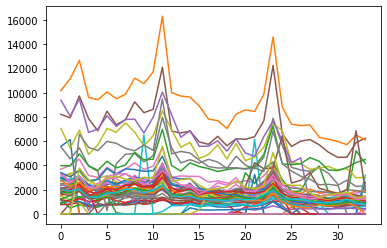

3648206.0

In [19]:
monthly_count_mat=np.zeros((60,34))
for shop in range(60):
  for block in range(34):
    monthly_count_mat[shop][block]=monthly_summary_train[(monthly_summary_train['shop_id']==shop) & (monthly_summary_train['date_block_num']==block)].sum()['item_cnt_day']

# monthly_count_mat
plt.plot(monthly_count_mat.transpose())
plt.show()
monthly_count_mat.sum()

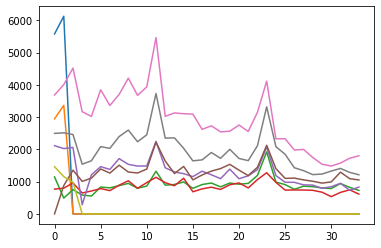

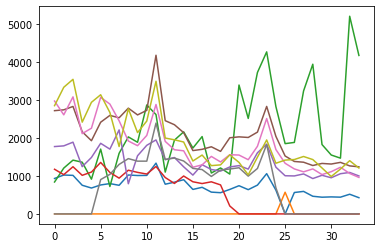

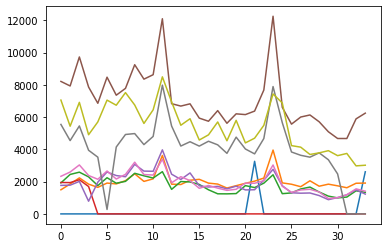

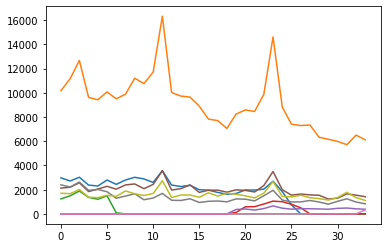

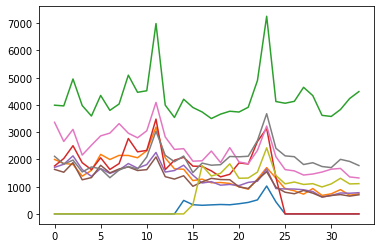

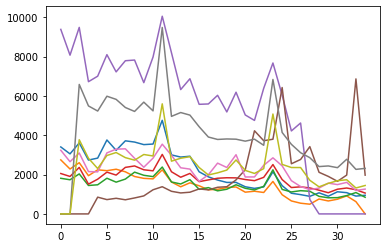

In [20]:

# try to make plots more readable by separating different shops 
# into a few different plots

plt.plot(monthly_count_mat[0:9,:].transpose())
plt.show()

plt.plot(monthly_count_mat[10:19,:].transpose())
plt.show()

plt.plot(monthly_count_mat[20:29,:].transpose())
plt.show()

plt.plot(monthly_count_mat[30:39,:].transpose())
plt.show()

plt.plot(monthly_count_mat[40:49,:].transpose())
plt.show()

plt.plot(monthly_count_mat[50:59,:].transpose())
plt.show()

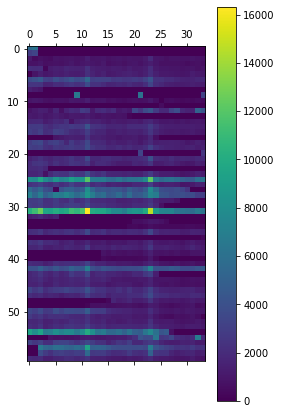

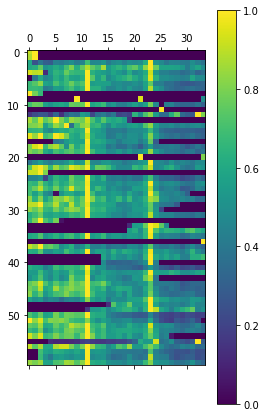

In [21]:
plt.matshow(monthly_count_mat)
plt.colorbar()
plt.show()

plt.matshow(monthly_count_mat/monthly_count_mat.max(axis=1, keepdims=True))
plt.colorbar()
plt.show()

Different shops certainly have different temporal patterns. Many do fit to the general pattern with linear trend and Christmas spikes. However, the strength of spikes and the direction of the trend varies. There are also some outliers with clearly different temporal patterns. Shop-wise prediction of sales could totally make sense as the larger shops strongly dominate the overall sales figures, but in scoring, the greater number of smaller shop predictions have larger significance due to the nature of the scoring function.

Let's now repeat the visualisations for test set shop_ids only, hopefully removing unneessary distraction from irrelevant anomalous shops.


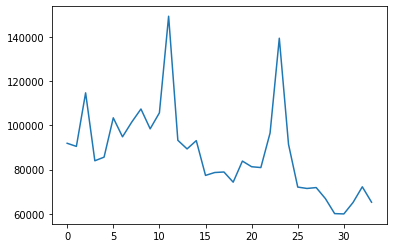

array([ 91888.,  90483., 114684.,  83983.,  85617., 103391.,  94814.,
       101461., 107386.,  98427., 105648., 149312.,  93242.,  89346.,
        93088.,  77371.,  78675.,  78909.,  74313.,  83844.,  81291.,
        80915.,  96534., 139377.,  91408.,  72096.,  71466.,  71869.,
        66871.,  60098.,  59961.,  65163.,  72220.,  65259.])

In [22]:
test_shops=np.array(test_spec['shop_id'].unique())
monthly_count_mat_testshops=monthly_count_mat[test_shops,:]

overall=monthly_count_mat_testshops.sum(axis=0)
#overall.shape

plt.plot(overall)
plt.show()
overall


The shape of overall sales curve is not affected very much. Let's now look at individual entries:

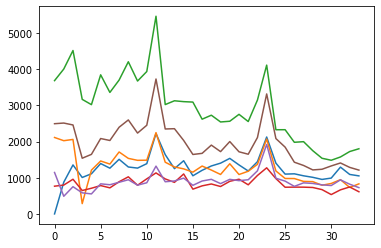

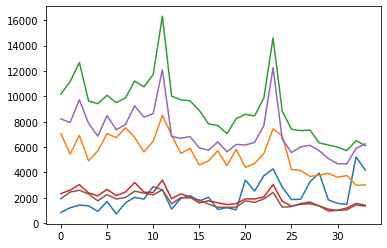

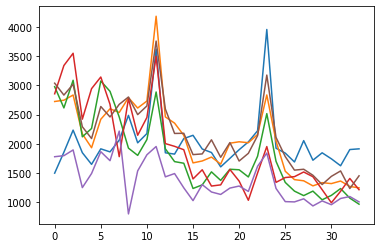

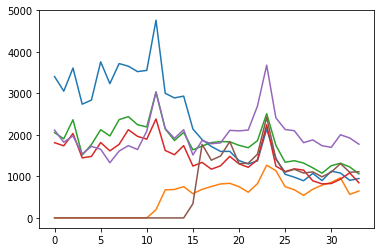

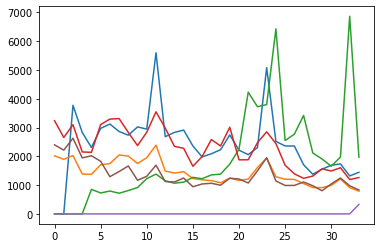

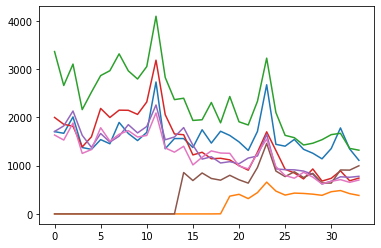

In [23]:
plt.plot(monthly_count_mat_testshops[0:6,:].transpose())
plt.show()

plt.plot(monthly_count_mat_testshops[7:13,:].transpose())
plt.show()

plt.plot(monthly_count_mat_testshops[14:20,:].transpose())
plt.show()

plt.plot(monthly_count_mat_testshops[21:27,:].transpose())
plt.show()

plt.plot(monthly_count_mat_testshops[28:34,:].transpose())
plt.show()

plt.plot(monthly_count_mat_testshops[35:,:].transpose())
plt.show()

These show that also the test set shops show temporal sales development patterns
that are rather different from the overall sales development. For example, some shops show almost no Christmas spikes at all.

Let's finally visualise the temporal patterns one shop at time in order to identify anomalous shops


shop_id:5 name:Вологда ТРЦ "Мармелад"


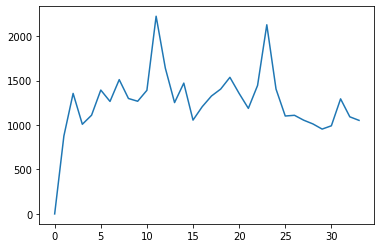

shop_id:4 name:Волжский ТЦ "Волга Молл"


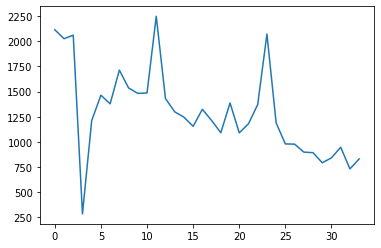

shop_id:6 name:Воронеж (Плехановская, 13)


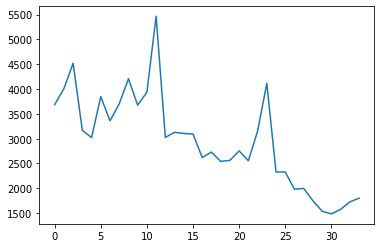

shop_id:3 name:Балашиха ТРК "Октябрь-Киномир"


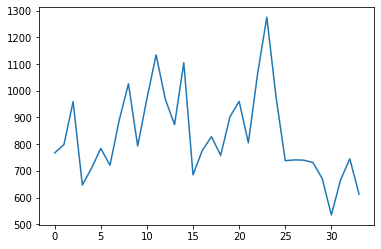

shop_id:2 name:Адыгея ТЦ "Мега"


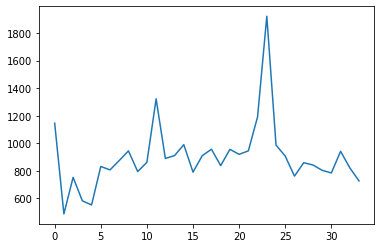

shop_id:7 name:Воронеж ТРЦ "Максимир"


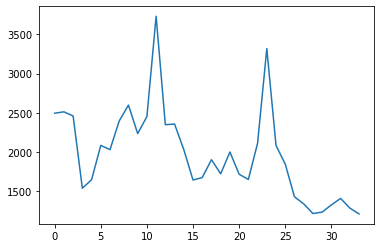

shop_id:10 name:Жуковский ул. Чкалова 39м?


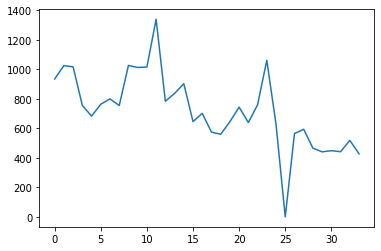

shop_id:12 name:Интернет-магазин ЧС


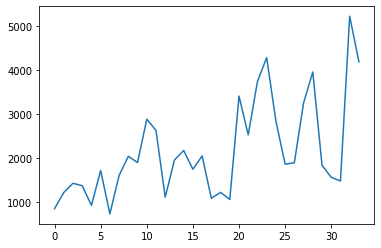

shop_id:28 name:Москва ТЦ "МЕГА Теплый Стан" II


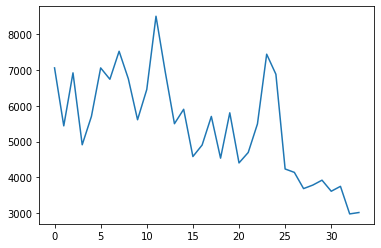

shop_id:31 name:Москва ТЦ "Семеновский"


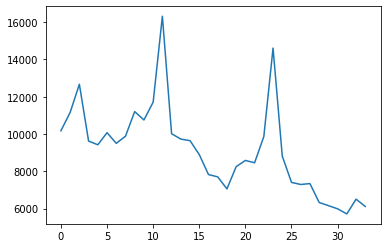

shop_id:26 name:Москва ТЦ "Ареал" (Беляево)


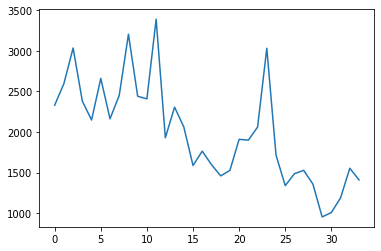

shop_id:25 name:Москва ТРК "Атриум"


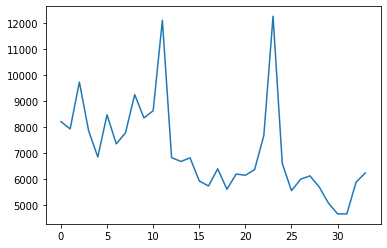

shop_id:22 name:Москва Магазин С21


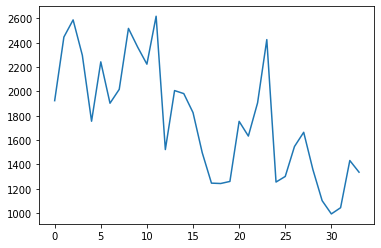

shop_id:24 name:Москва ТК "Буденовский" (пав.К7)


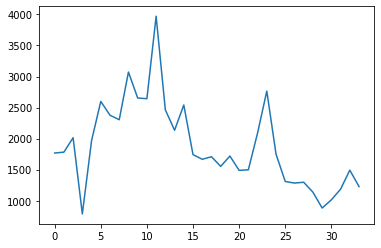

shop_id:21 name:Москва МТРЦ "Афи Молл"


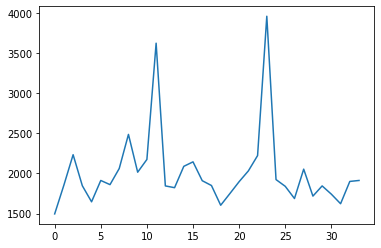

shop_id:15 name:Калуга ТРЦ "XXI век"


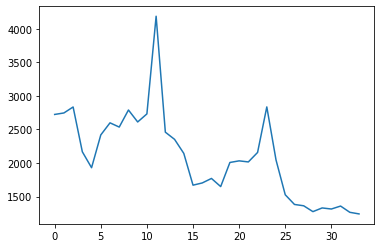

shop_id:16 name:Коломна ТЦ "Рио"


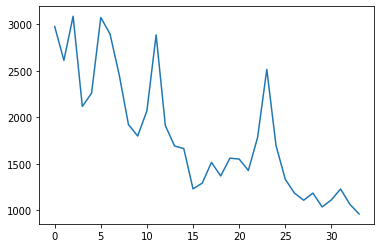

shop_id:18 name:Красноярск ТЦ "Июнь"


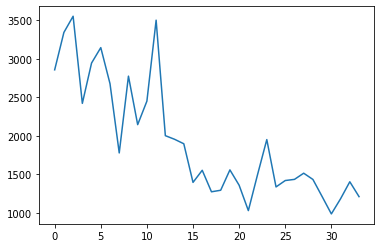

shop_id:14 name:Казань ТЦ "ПаркХаус" II


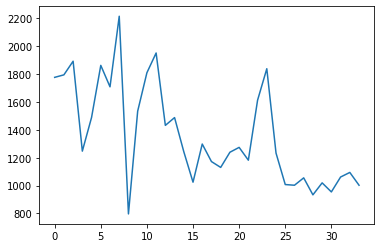

shop_id:19 name:Курск ТЦ "Пушкинский"


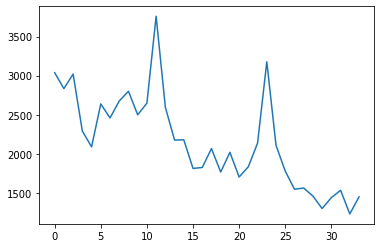

shop_id:42 name:СПб ТК "Невский Центр"


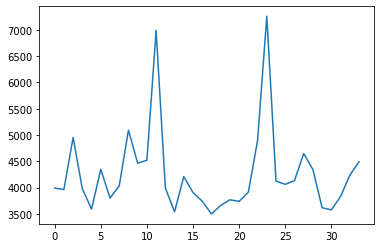

shop_id:50 name:Тюмень ТЦ "Гудвин"


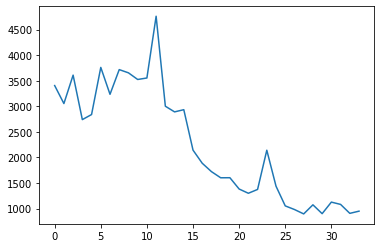

shop_id:49 name:Тюмень ТРЦ "Кристалл"


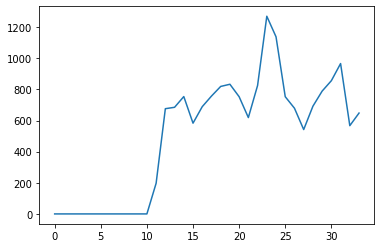

shop_id:53 name:Уфа ТЦ "Семья" 2


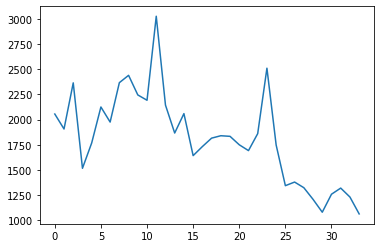

shop_id:52 name:Уфа ТК "Центральный"


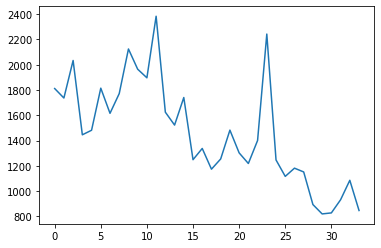

shop_id:47 name:Сургут ТРЦ "Сити Молл"


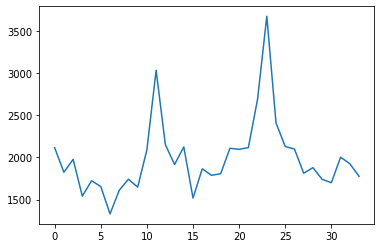

shop_id:48 name:Томск ТРЦ "Изумрудный Город"


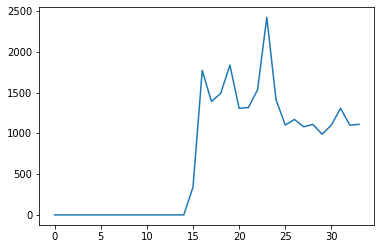

shop_id:57 name:Якутск Орджоникидзе, 56


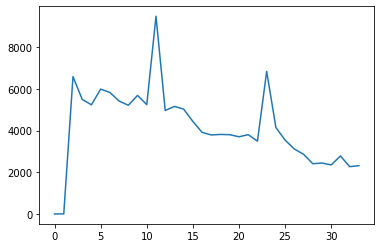

shop_id:58 name:Якутск ТЦ "Центральный"


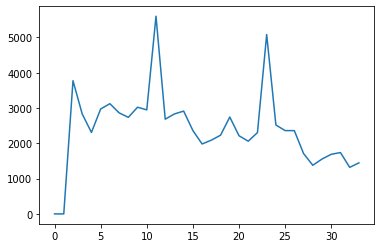

shop_id:59 name:Ярославль ТЦ "Альтаир"


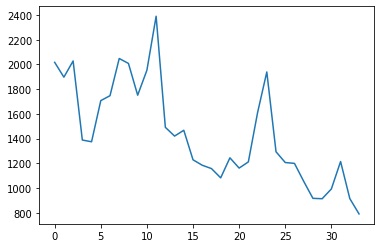

shop_id:55 name:Цифровой склад 1С-Онлайн


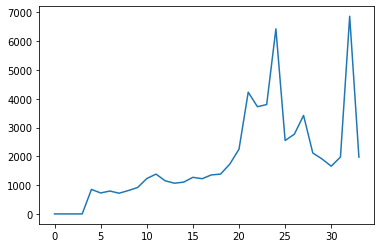

shop_id:56 name:Чехов ТРЦ "Карнавал"


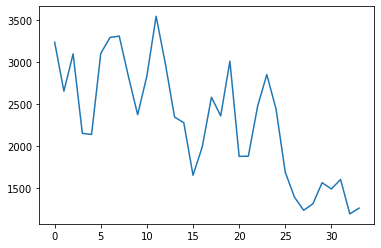

shop_id:36 name:Новосибирск ТРЦ "Галерея Новосибирск"


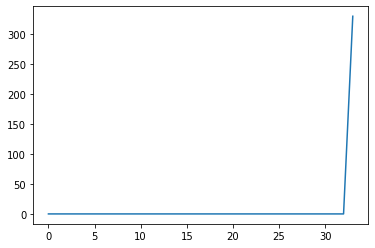

shop_id:37 name:Новосибирск ТЦ "Мега"


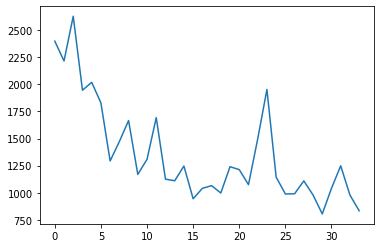

shop_id:35 name:Н.Новгород ТРЦ "Фантастика"


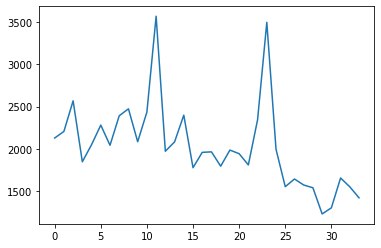

shop_id:38 name:Омск ТЦ "Мега"


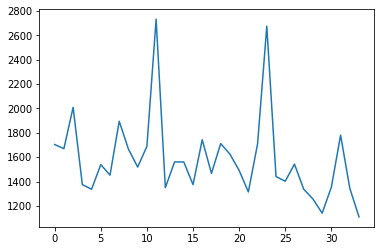

shop_id:34 name:Н.Новгород ТРЦ "РИО"


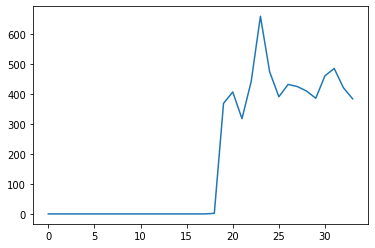

shop_id:46 name:Сергиев Посад ТЦ "7Я"


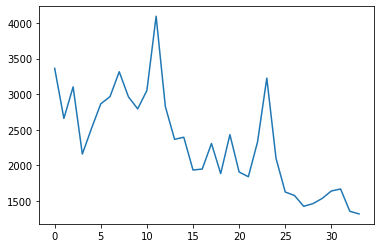

shop_id:41 name:РостовНаДону ТЦ "Мега"


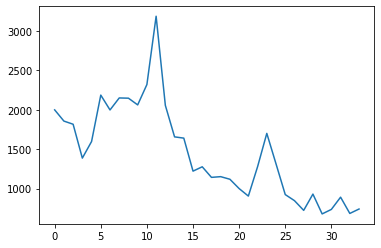

shop_id:44 name:Самара ТЦ "Мелодия"


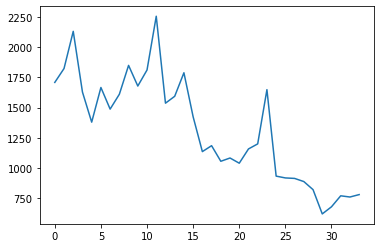

shop_id:39 name:РостовНаДону ТРК "Мегацентр Горизонт"


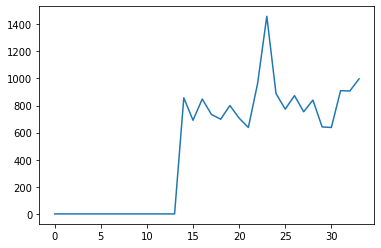

shop_id:45 name:Самара ТЦ "ПаркХаус"


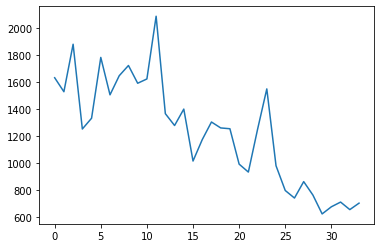

In [24]:
for idx in range(42):
  print('shop_id:{} name:{}'.format(test_shops[idx],shops['shop_name'][test_shops[idx]]))
  plt.plot(monthly_count_mat_testshops[idx,:].transpose())
  plt.show()


Shops 49 and 50 (both in Tjumen) seem to have strong interaction of sales figures. AFter shop 49 opened, the sales of shop 50 drastically dropped

Shops 12 and 55 have rather untypical time development of sales, and by looking at the shop names, they are identified as online stores.


### Sales by category

In [25]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


There are 84 product categories in total. Only 62 of them appear in the test set.


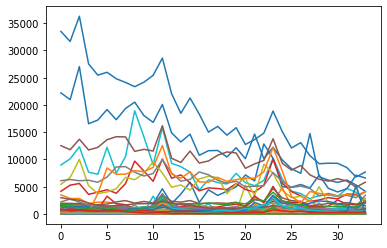

In [26]:

monthly_summary_with_categories=monthly_summary_train.join(items, on='item_id', rsuffix='_item')

n_categories = 84

monthly_count_mat=np.zeros((n_categories,34))
for category in range(n_categories):
  for block in range(34):
    monthly_count_mat[category,block]=monthly_summary_with_categories[(monthly_summary_with_categories['item_category_id']==category) & 
                                                                      (monthly_summary_with_categories['date_block_num']==block)].sum()['item_cnt_day']

# monthly_count_mat
plt.plot(monthly_count_mat.transpose())
plt.show()

In [27]:
monthly_count_mat.sum()

3648206.0

In [28]:
item_categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


Take a look at categories individually

category_id:0 name:PC - Гарнитуры/Наушники
Category included in test


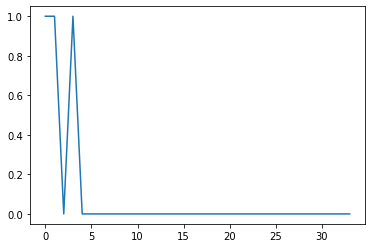

category_id:1 name:Аксессуары - PS2
Category not in test


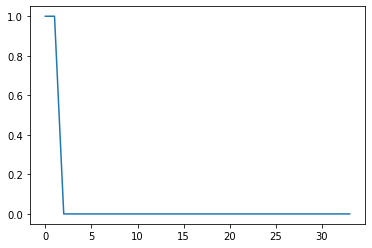

category_id:2 name:Аксессуары - PS3
Category included in test


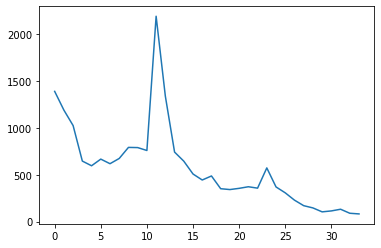

category_id:3 name:Аксессуары - PS4
Category included in test


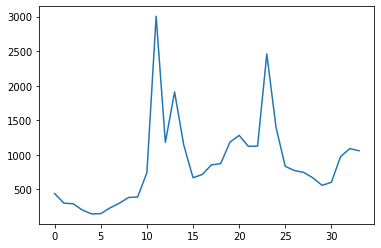

category_id:4 name:Аксессуары - PSP
Category not in test


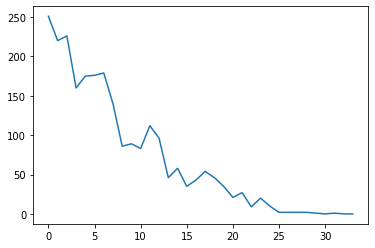

category_id:5 name:Аксессуары - PSVita
Category included in test


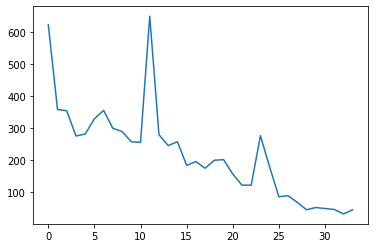

category_id:6 name:Аксессуары - XBOX 360
Category included in test


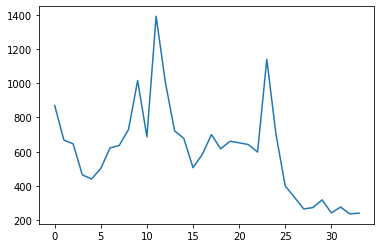

category_id:7 name:Аксессуары - XBOX ONE
Category included in test


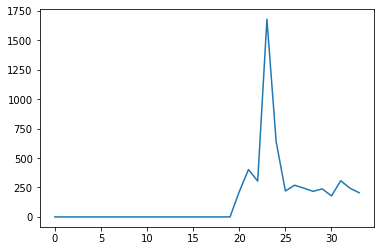

category_id:8 name:Билеты (Цифра)
Category not in test


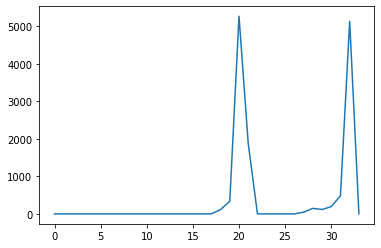

category_id:9 name:Доставка товара
Category included in test


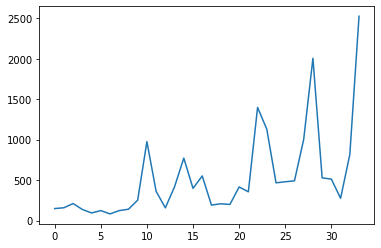

category_id:10 name:Игровые консоли - PS2
Category not in test


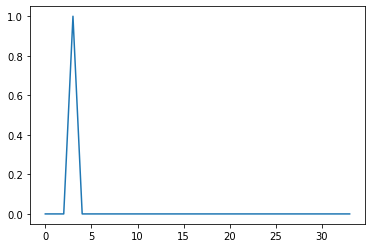

category_id:11 name:Игровые консоли - PS3
Category included in test


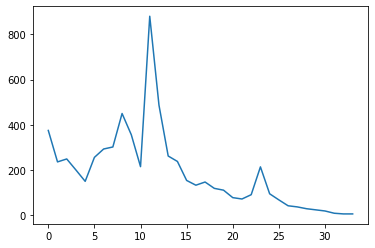

category_id:12 name:Игровые консоли - PS4
Category included in test


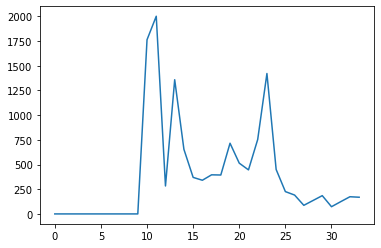

category_id:13 name:Игровые консоли - PSP
Category not in test


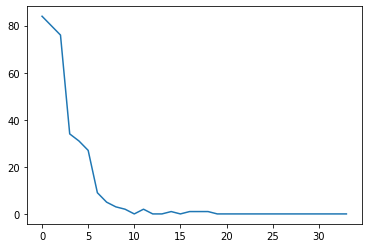

category_id:14 name:Игровые консоли - PSVita
Category not in test


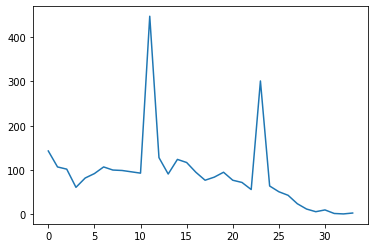

category_id:15 name:Игровые консоли - XBOX 360
Category included in test


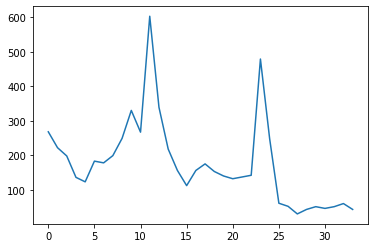

category_id:16 name:Игровые консоли - XBOX ONE
Category included in test


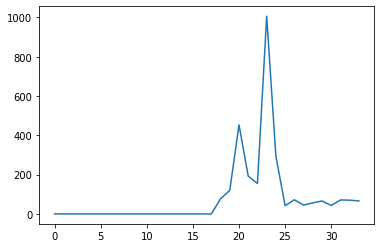

category_id:17 name:Игровые консоли - Прочие
Category not in test


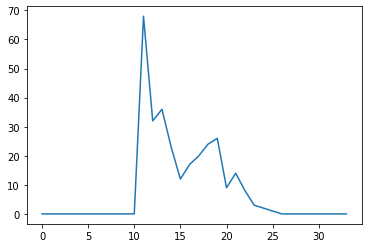

category_id:18 name:Игры - PS2
Category not in test


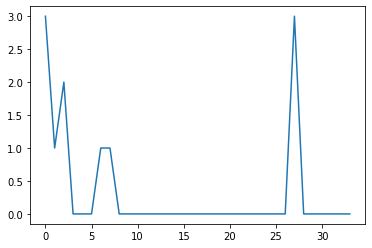

category_id:19 name:Игры - PS3
Category included in test


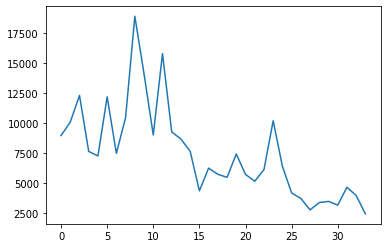

category_id:20 name:Игры - PS4
Category included in test


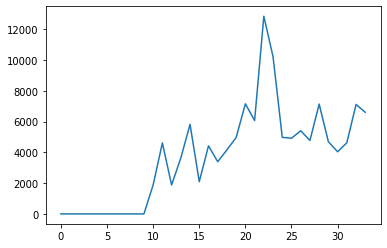

category_id:21 name:Игры - PSP
Category included in test


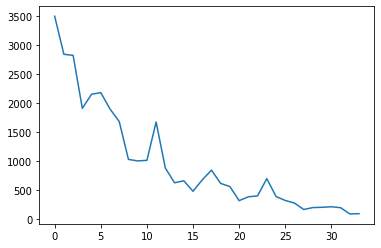

category_id:22 name:Игры - PSVita
Category included in test


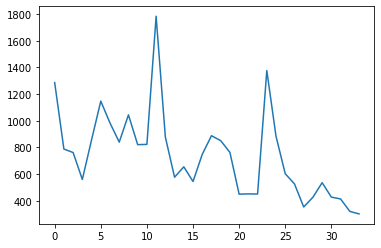

category_id:23 name:Игры - XBOX 360
Category included in test


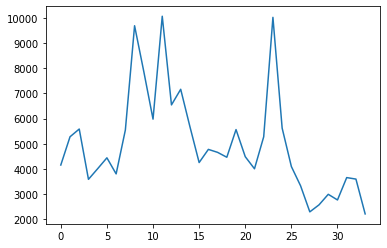

category_id:24 name:Игры - XBOX ONE
Category included in test


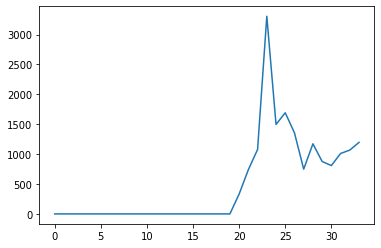

category_id:25 name:Игры - Аксессуары для игр
Category included in test


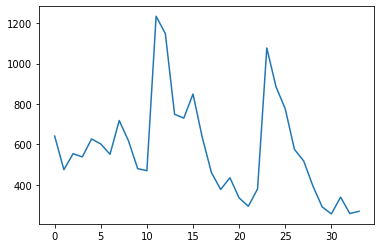

category_id:26 name:Игры Android - Цифра
Category included in test


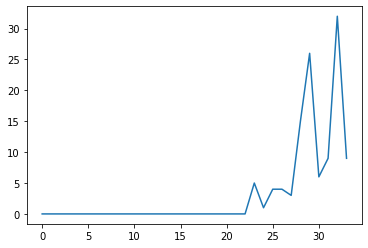

category_id:27 name:Игры MAC - Цифра
Category included in test


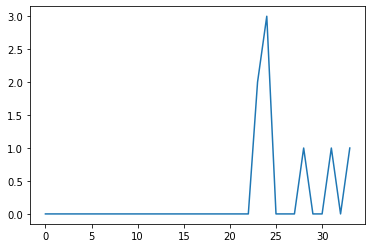

category_id:28 name:Игры PC - Дополнительные издания
Category included in test


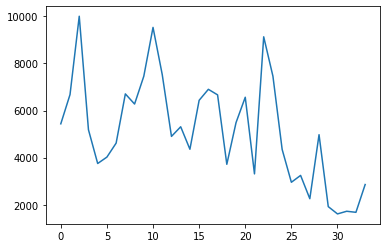

category_id:29 name:Игры PC - Коллекционные издания
Category included in test


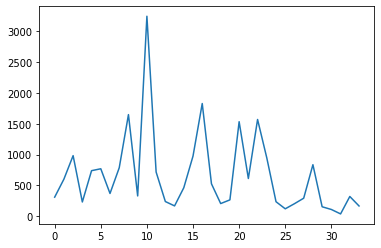

category_id:30 name:Игры PC - Стандартные издания
Category included in test


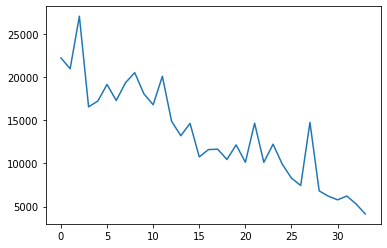

category_id:31 name:Игры PC - Цифра
Category included in test


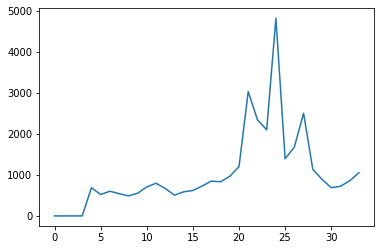

category_id:32 name:Карты оплаты (Кино, Музыка, Игры)
Category not in test


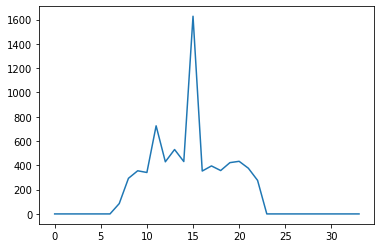

category_id:33 name:Карты оплаты - Live!
Category included in test


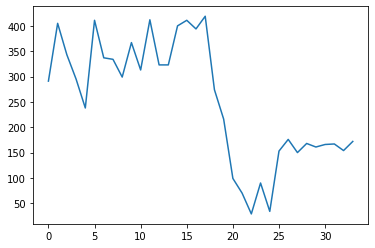

category_id:34 name:Карты оплаты - Live! (Цифра)
Category included in test


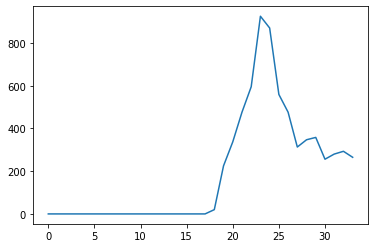

category_id:35 name:Карты оплаты - PSN
Category included in test


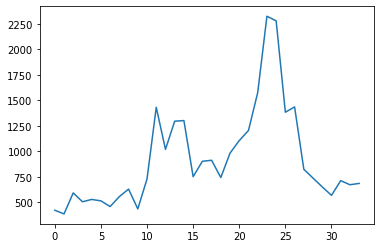

category_id:36 name:Карты оплаты - Windows (Цифра)
Category included in test


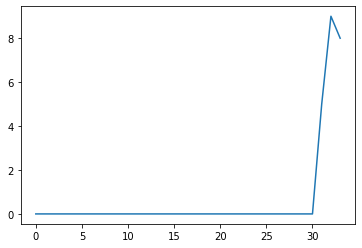

category_id:37 name:Кино - Blu-Ray
Category included in test


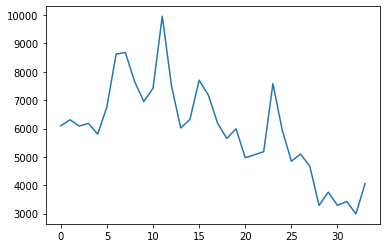

category_id:38 name:Кино - Blu-Ray 3D
Category included in test


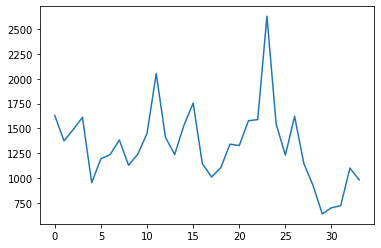

category_id:39 name:Кино - Blu-Ray 4K
Category not in test


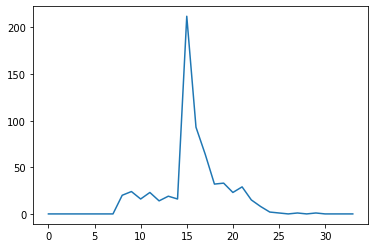

category_id:40 name:Кино - DVD
Category included in test


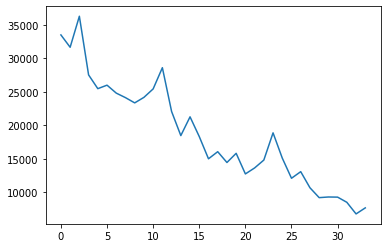

category_id:41 name:Кино - Коллекционное
Category included in test


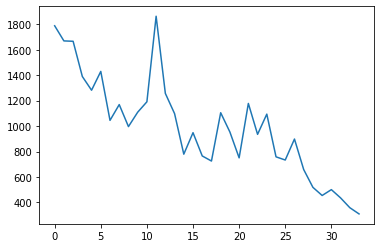

category_id:42 name:Книги - Артбуки, энциклопедии
Category included in test


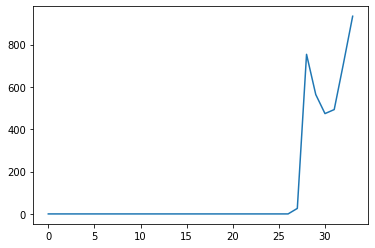

category_id:43 name:Книги - Аудиокниги
Category included in test


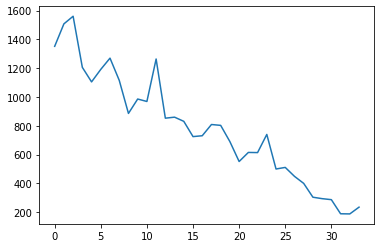

category_id:44 name:Книги - Аудиокниги (Цифра)
Category included in test


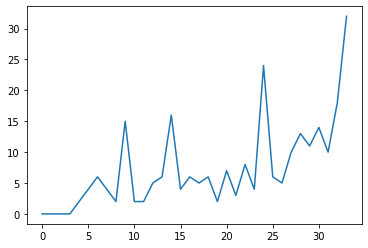

category_id:45 name:Книги - Аудиокниги 1С
Category included in test


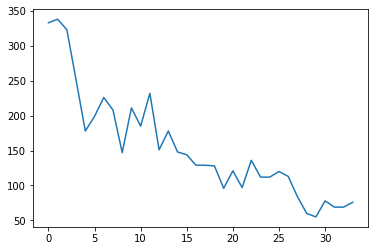

category_id:46 name:Книги - Бизнес литература
Category not in test


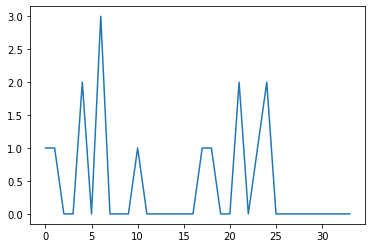

category_id:47 name:Книги - Комиксы, манга
Category included in test


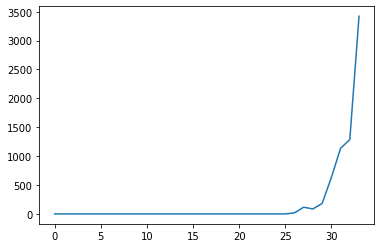

category_id:48 name:Книги - Компьютерная литература
Category not in test


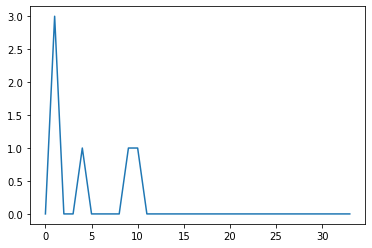

category_id:49 name:Книги - Методические материалы 1С
Category included in test


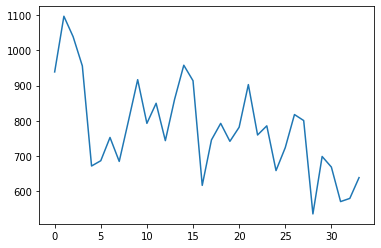

category_id:50 name:Книги - Открытки
Category not in test


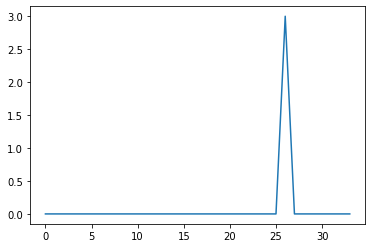

category_id:51 name:Книги - Познавательная литература
Category not in test


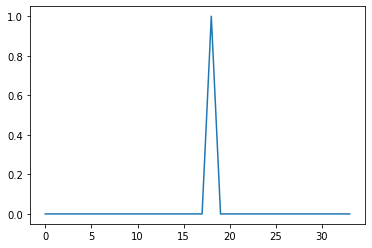

category_id:52 name:Книги - Путеводители
Category not in test


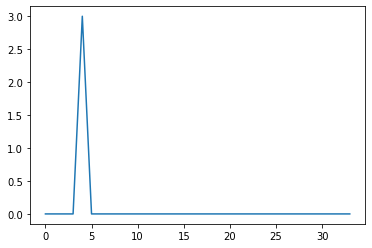

category_id:53 name:Книги - Художественная литература
Category not in test


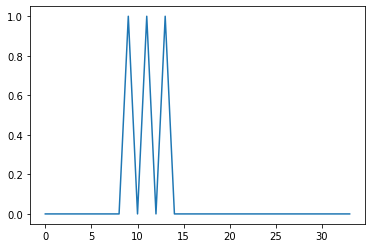

category_id:54 name:Книги - Цифра
Category included in test


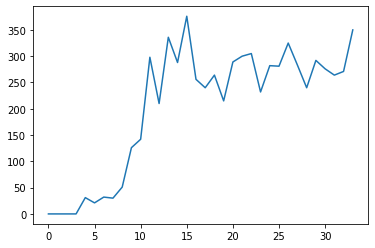

category_id:55 name:Музыка - CD локального производства
Category included in test


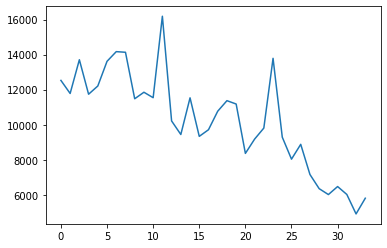

category_id:56 name:Музыка - CD фирменного производства
Category included in test


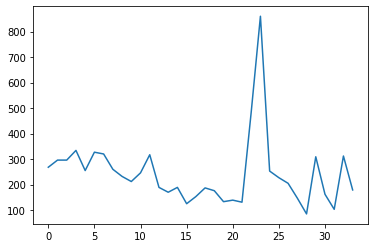

category_id:57 name:Музыка - MP3
Category included in test


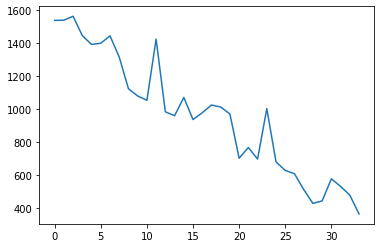

category_id:58 name:Музыка - Винил
Category included in test


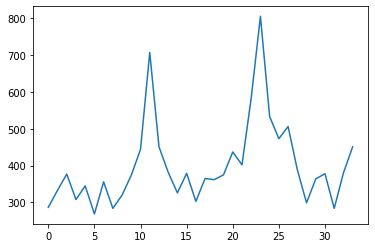

category_id:59 name:Музыка - Музыкальное видео
Category not in test


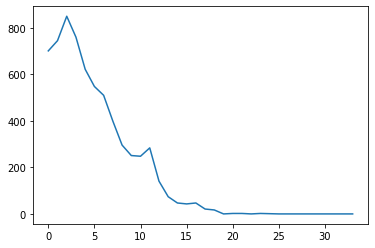

category_id:60 name:Музыка - Подарочные издания
Category included in test


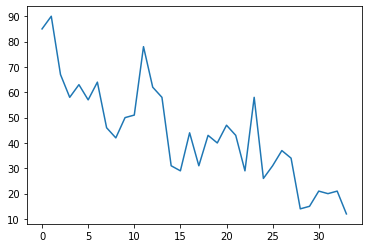

category_id:61 name:Подарки - Атрибутика
Category included in test


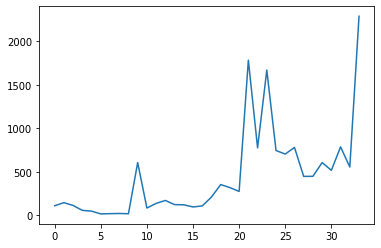

category_id:62 name:Подарки - Гаджеты, роботы, спорт
Category included in test


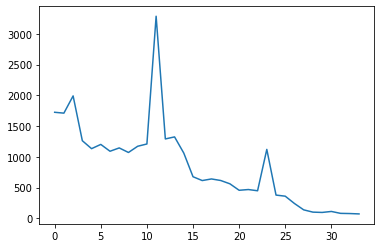

category_id:63 name:Подарки - Мягкие игрушки
Category included in test


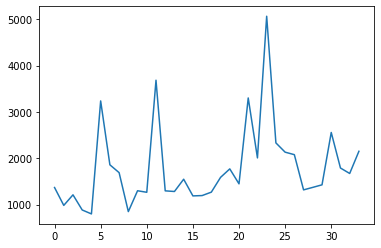

category_id:64 name:Подарки - Настольные игры
Category included in test


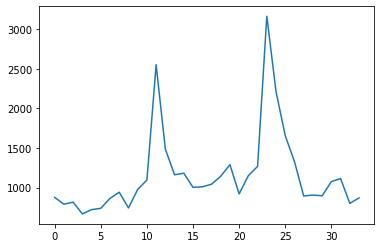

category_id:65 name:Подарки - Настольные игры (компактные)
Category included in test


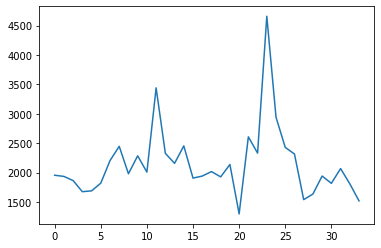

category_id:66 name:Подарки - Открытки, наклейки
Category not in test


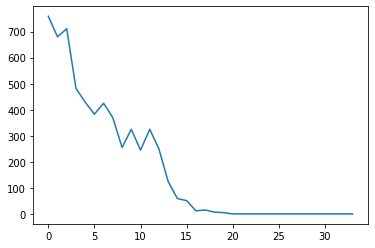

category_id:67 name:Подарки - Развитие
Category included in test


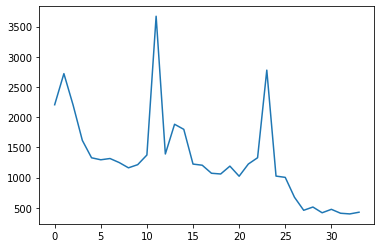

category_id:68 name:Подарки - Сертификаты, услуги
Category not in test


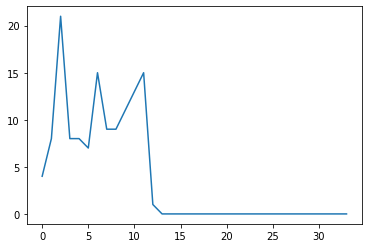

category_id:69 name:Подарки - Сувениры
Category included in test


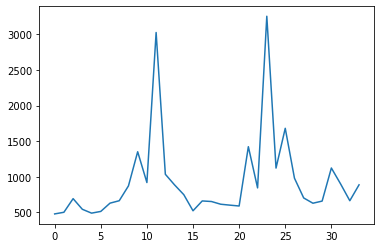

category_id:70 name:Подарки - Сувениры (в навеску)
Category included in test


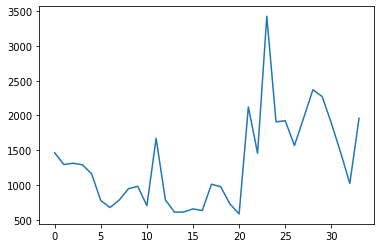

category_id:71 name:Подарки - Сумки, Альбомы, Коврики д/мыши
Category included in test


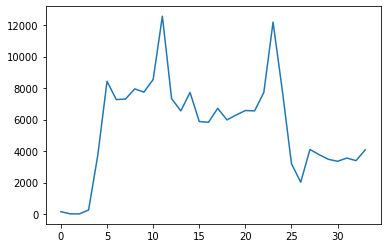

category_id:72 name:Подарки - Фигурки
Category included in test


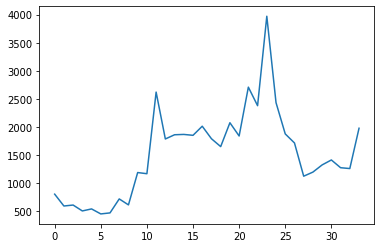

category_id:73 name:Программы - 1С:Предприятие 8
Category included in test


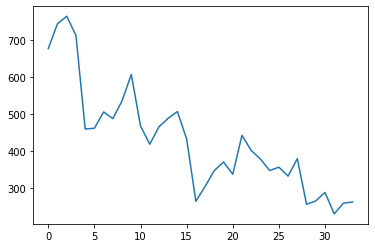

category_id:74 name:Программы - MAC (Цифра)
Category included in test


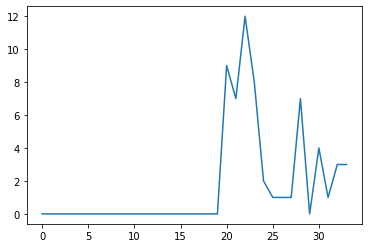

category_id:75 name:Программы - Для дома и офиса
Category included in test


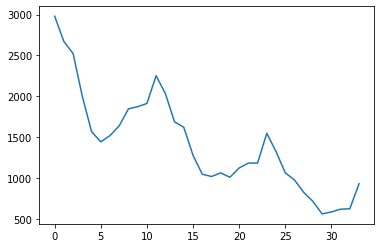

category_id:76 name:Программы - Для дома и офиса (Цифра)
Category included in test


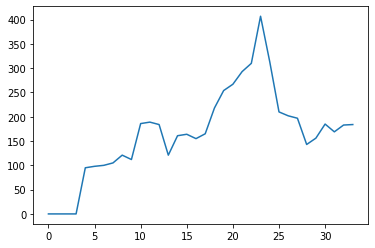

category_id:77 name:Программы - Обучающие
Category included in test


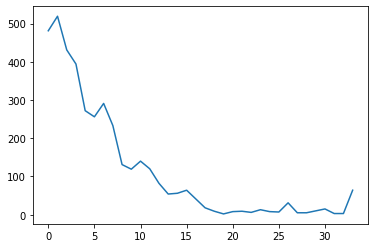

category_id:78 name:Программы - Обучающие (Цифра)
Category included in test


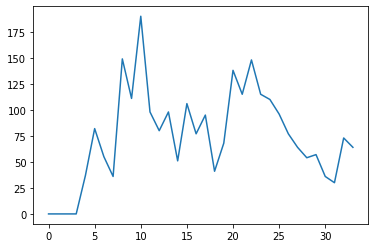

category_id:79 name:Служебные
Category included in test


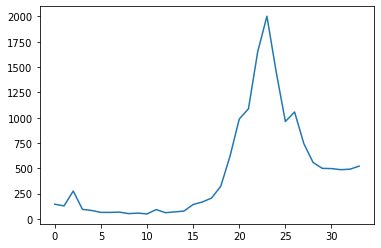

category_id:80 name:Служебные - Билеты
Category not in test


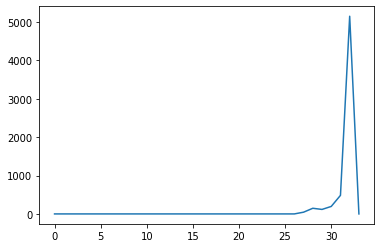

category_id:81 name:Чистые носители (шпиль)
Category not in test


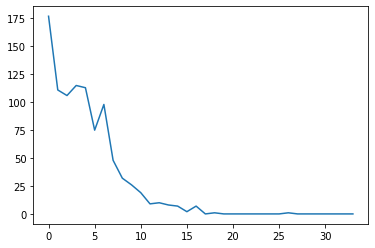

category_id:82 name:Чистые носители (штучные)
Category not in test


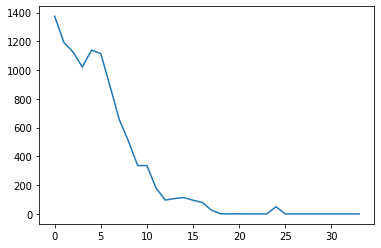

category_id:83 name:Элементы питания
Category included in test


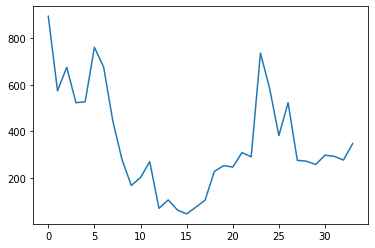

In [29]:
for category in range(n_categories):
  print('category_id:{} name:{}'.format(category,item_categories['item_category_name'][category]))
  if category in test_categories:
    print('Category included in test')
  else:
    print('Category not in test')
  plt.plot(monthly_count_mat[category,:].transpose())
  plt.show()

What is the meaning of categories "tsifra"? Tend to have smaller numbers?

Lets look at price distribution and it's effect on sales.

Lets now how long items live in the supply of the shops. Let's look at the first appearances of the test items in the transactions:

[[939.  66.  58.  56.  98.  54.  43.  52.  69. 112.  92. 103.  48.  82.
   71.  88.  79.  88. 114.  96. 134. 197. 201. 200.  77.  96. 171. 148.
  137. 154. 122. 204. 205. 283.   0.   0.]]


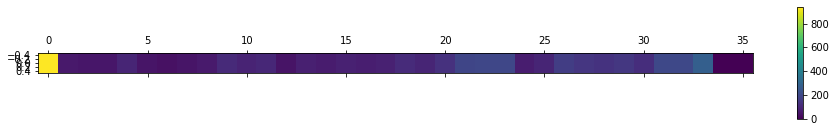

In [30]:
first_appearance = np.zeros((1,36))

for item in test_items:
  first=transactions[transactions['item_id'] == item]['date_block_num'].min()
  
  if first == first: # skip nans
    first_appearance[0,first] = first_appearance[0,first] + 1
  # print("item {}: first date block {}".format(item, first))

print(first_appearance)
plt.matshow(first_appearance)
plt.colorbar()
plt.show()

There's rather even spread in times of introduction. That is, some tested products have been in inventory for long time and some for short time.

Let's repeat this category-wise

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


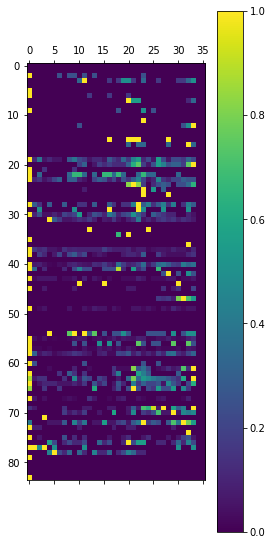

In [31]:
first_appearance = np.zeros((item_categories.shape[0],36))

for item in test_items:
  category=int(items[items['item_id']==item].item_category_id)
  first=transactions[transactions['item_id'] == item]['date_block_num'].min()
  
  if first == first: # skip nans
    first_appearance[category,first] = first_appearance[category,first] + 1
  # print("item {}: first date block {}".format(item, first))

print(safe_div(first_appearance,first_appearance.max(axis=1,keepdims=True)))

plt.matshow(safe_div(first_appearance, first_appearance.max(axis=1,keepdims=True)))
plt.colorbar()
plt.show()



It's not obvious if we can get any additional understanding from these plots, but in any case we would need to have have strategy for new products and products not sold for all of the training period.

However, in this barebones solution we deliberately ignore these aspects.

Let's now compare the inventories of different shops at a certain time. Let's look at the last month of training (index=33)

Here on now on we use the word 'inventory' to denote the set of item_id's sold during a certain period of time. Either overall, or in a given shop.



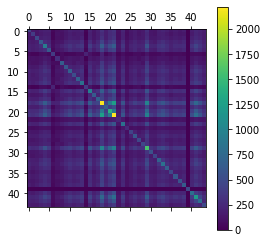

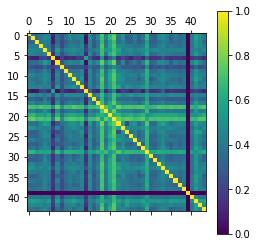

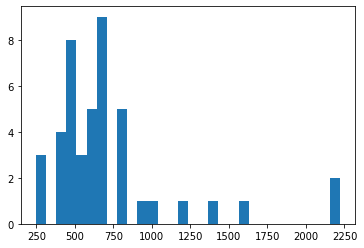

[ 440.  391.  478.  615.  954.  642.  390.  288.  650.  594.  693.  535.
  681.  824.  387.  974.  626.  660. 2210.  680. 1398. 2222.  246.  820.
  258.  444.  605.  482.  476. 1573.  549.  466.  700.  831.  653.  482.
  603.  573.  646.  470.  802. 1216.  804.  500.]


In [32]:
df_oct15=monthly_summary_train[monthly_summary_train['date_block_num'] == 33]
items_oct15=np.array(df_oct15['item_id'].unique())
shops_oct15=np.array(df_oct15['shop_id'].unique())
inventory_matrix_oct15 = np.zeros((len(shops_oct15),items.shape[0]))


for shopidx in range(len(shops_oct15)):
  items_shop = np.array(df_oct15[df_oct15['shop_id'] == shops_oct15[shopidx]]['item_id'].unique())
  inventory_matrix_oct15[shopidx,items_shop]=1

common_item_count = np.matmul(inventory_matrix_oct15, inventory_matrix_oct15.transpose())

plt.matshow(common_item_count)
plt.colorbar()
plt.show()

inventory_size = np.sum(inventory_matrix_oct15, axis = 1)

common_item_fraction = common_item_count

for index, val in np.ndenumerate(common_item_count):
  common_item_fraction[index[0],index[1]] = val / min(inventory_size[index[0]], inventory_size[index[1]])

plt.matshow(common_item_fraction)
plt.colorbar()
plt.show()

plt.hist(inventory_size, bins=30)
plt.show()

print(inventory_size)



These figures give arise to the following observations:
- in a given month, most of the stores sell only a small fraction of item types available in the active product catalogue
- the overlap in the item type lists sold in different stores is not very strong

 Next interesting thing to check would be whether the inventory (list of item id's sold) stays constant between different months for a given shop. That is, if we wanted to really obtain good performance in the task. This time we just try to generate a sufficiently good solution to pass the course.

 All this raises a suspicion that the sold amounts are so small that the set of items sold in a given shop in a given month contains so much random fluctuation that very detailed prediction models may not be the best way to approach the problem. At least one could start by predicting aggregate statistics for Dec'15 and modelling the way the sales should divide between shops and product, given the aggregates.

 Another thought is that aggregating training data with a month-long window is kind of artificial and unnecessarily wastes some information. One might be better off fitting a temporally finer-grained day-based model producing discrete spikes and aggregating the predictions over one month. Or even a model that generates a sequence of transaction events. Such temporally fine-grained model could summarize over some other aspects of the data. Such as generate transaction labels only on product category level.



# Conclusion

There would seem to be many interesting properties in the data that could be exploited to make sales predictions. Especially important aspects that will be almost completely ignored in this straightforward solution would be the temporal patterns the overall sales and particular shops exhibit,  the yearly cycle in particular.

